# Building a postgres database

In this project from the dataquests "Postgres for Data Engineers" course, I am going to put my knowledge to the test and create a database from a file named *boston.csv*, containing detailed info on crimes that occurred in Boston, Massachusetts. 

The goal is to build a database named *crimes_db*, containing one table - *boston_crimes*. The table will store the data from the *boston.csv*-file with appropriate datatypes to optimize diskspace.

The table will be nested in a schema named *crimes*. 

The database will have two user groups - *readonly* and *readwrite* with appropriate privileges and one user each.

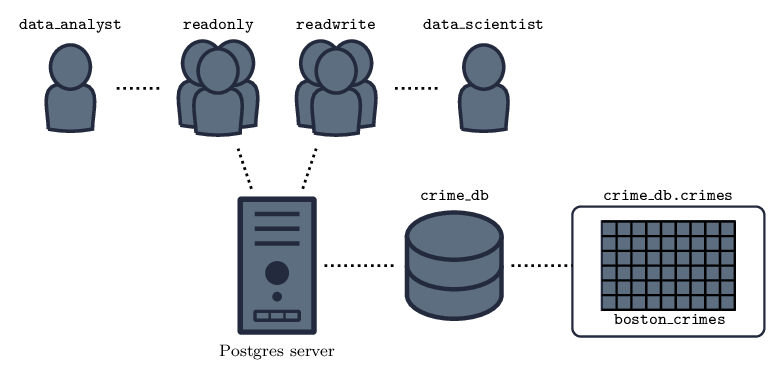

Source: Diagram taken from [dataquest.io](https://app.dataquest.io/m/251/guided-project%3A-building-a-database-for-crime-reports/1/introduction)

In [ ]:
import psycopg2
conn = psycopg2.connect(dbname="postgres", user="postgres", password="DubGxB#E5q&e")

"""
To create a database, we need to set autocommit to true, since we can´t create a db within a transaction block.
The command needs to be executed immediately and without any other commands!
"""

conn.autocommit = True
cur=conn.cursor()
cur.execute("CREATE DATABASE crime_db;")
conn.autocommit = False
conn.close()

In [1]:
# Connect to the newly created db and create schema named crimes
import psycopg2
conn = psycopg2.connect(dbname="crime_db", user="postgres", password="xxxx")
cur = conn.cursor()
cur.execute("CREATE SCHEMA crimes;")

In [2]:
# import our data

import csv
with open(r"insert_path_to_file\boston.csv","r") as f:
    reader = csv.reader(f)    
# assign header row and first row to variables
# The data will help us when creating the table, since we won´t need to remember the column names
# and we can check the data contained in each column
    col_headers = next(reader)
    first_row = next(reader)
    
    print(col_headers)
    print(first_row)

['incident_number', 'offense_code', 'description', 'date', 'day_of_the_week', 'lat', 'long']
['1', '619', 'LARCENY ALL OTHERS', '2018-09-02', 'Sunday', '42.35779134', '-71.13937053']


In [3]:
"""
I will now define a function that will fetch data from a specific column in our tabular dataset 
and return it as a Python set 
This function will be useful for two reasons:
    1. Checking whether an enumerated datatype might be a good choice for representing a column.
    2. Computing the maximum length of any text-like column to select appropriate sizes for VARCHAR columns.

"""

import pandas as pd
def get_col_set(csv_path, col_index):
    col_set = pd.read_csv(csv_path, usecols= [col_index])
    col_set = set(col_set.iloc[:,0])
    return col_set

"""
Get count of unique values for every colum using a for-loop.
"""   
csv_path = r"insert_path_to_file\boston.csv"
for index in range (0,len(col_headers)):
    col_set = len(get_col_set(csv_path,index))
    
    print("Unique values in {} : {}".format(col_headers[index],col_set))
    

Unique values in incident_number : 298329
Unique values in offense_code : 219
Unique values in description : 239
Unique values in date : 1177
Unique values in day_of_the_week : 7
Unique values in lat : 18177
Unique values in long : 18177


In [4]:
"""
Iterate over entries in description text column and find the maximum character-length
to decide on parameters for varchar
day_of_the_week column contains the weekday names, so "Wednesday" will be the longest possible entry
"""

description = get_col_set(csv_path,2)

length = 0
for word in description:
    length = max(length, len(word))
print("Maximum characters in description: {}".format(length))


"""
Check Max and/or Min values for numeric columns to determine optimal datatype
"""
cols = [1,5,6]

for col in cols:
    variable = get_col_set(csv_path,col)
    print("Col: {}, max: {}, min: {}".format(col_headers[col], max(variable),(min(variable))))



Maximum characters in description: 58
Col: offense_code, max: 3831, min: 111
Col: lat, max: 42.39504158, min: 42.2324133
Col: long, max: -70.96367615, min: -71.17867378


In [ ]:
"""
Creating a table named boston_crimes inside the crimes schema of the crime_db database.

incident_number: here I chose SERIAl, a numeric dtype with only positive values. Since we can´t have negatives 
in this column, it seems like the obvious choice with a range from 1 to 2147483647

offense_code: SMALLSERIAL, 2 bytes for numbers from 1 to 32767. Max value is 3831

description: VARCHAR (100) Only 58 characters for description column necessary, but there might arise problems when 
new offenses and corresponding descriptions are added to the catalogue. Therefore I decided for 100 characters. 

Since day_of_the_week can only have 7 distinct values, it is advisable to use ENUM type
We need to create the ENUM type before creating the boston_crimes table, so we don´t have to set a dtype first 
and then cast it as ENUM retroactively
"""
cur.execute("""CREATE TYPE weekday AS ENUM ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday');""")


cur.execute("""CREATE TABLE crimes.boston_crimes (
            incident_number SERIAL PRIMARY KEY,
            offense_code SMALLSERIAL,
            description VARCHAR(100),
            date DATE,
            day_of_the_week weekday,
            lat DECIMAL,
            long DECIMAL
           );""")


In [ ]:
"""
After creating a Schema and the table, we can now populate the table with the data from our .csv-file
"""
with open(r"C:\Users\JulianSternitzke\OneDrive - heyworld GmbH\E-Books and other resources\03 - Dataquest\boston.csv","r") as f: 
    cur.copy_expert("COPY crimes.boston_crimes FROM STDIN WITH CSV HEADER;", f)

    

The database is all set up and should look like this: 

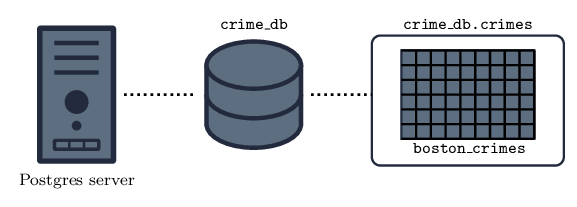

Now it´s time for user- and access-management.

In [5]:
"""
Following the POLP-principle, we start by revoking all privileges from the public-group to 
prevent any potential inheritance-problems to other groups
"""

cur.execute("REVOKE ALL ON SCHEMA public FROM public;")
cur.execute("REVOKE ALL ON DATABASE crime_db FROM public;")

"""
Now we create our readonly and readwrite user-groups and grant 
a) connection rights to connect to the database
b) access rights to the schema and
c) the privileges to interact with the tables in the schema
"""

cur.execute("CREATE GROUP readonly NOLOGIN;")
cur.execute("CREATE GROUP readwrite NOLOGIN;")

cur.execute("GRANT CONNECT ON DATABASE crime_db TO readonly;")
cur.execute("GRANT CONNECT ON DATABASE crime_db TO readwrite;")

cur.execute("GRANT USAGE ON SCHEMA crimes TO readonly;")
cur.execute("GRANT USAGE ON SCHEMA crimes TO readwrite;")

cur.execute("GRANT SELECT ON ALL TABLES IN SCHEMA crimes TO readonly;")
cur.execute("GRANT INSERT, SELECT, UPDATE, DELETE ON ALL TABLES IN SCHEMA crimes TO readwrite;")

We are now through with the infrastructure setup of the database, looking like this: 

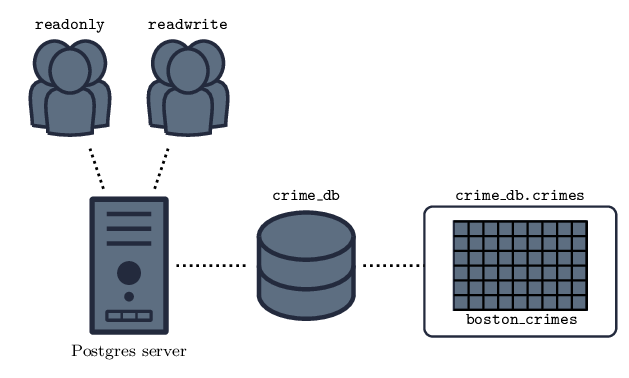

The last task we have to do is populate the database with users, that can interact with the database.



In [6]:
cur.execute("""CREATE USER data_analyst WITH PASSWORD 'secret1';""")
cur.execute("""CREATE USER data_scientist WITH PASSWORD 'secret2';""")
cur.execute("GRANT readonly TO data_analyst;")
cur.execute("GRANT readwrite TO data_scientist;")

In [7]:
"""
Commit all changes in the transaction blocks and close the connection
"""
conn.commit()
conn.close()

Now the Postgres database is all set up! Anyhow, it is good practice to check, if everything worked as expected.
This can be done by using SQL-queries to inspect the Postgres internal tables to verify that the objects like tables and schemas have been created and that all users and groups have the intended privileges.

In [9]:
import psycopg2
conn = psycopg2.connect(dbname="crime_db", user="postgres", password="DubGxB#E5q&e")
cur = conn.cursor()

In [12]:
# check users and groups
cur.execute("""
    SELECT rolname, rolsuper, rolcreaterole, rolcreatedb, rolcanlogin FROM pg_roles
    WHERE rolname IN ('readonly', 'readwrite', 'data_analyst', 'data_scientist');
""")
for user in cur:
    print(user)
print()
# check privileges
cur.execute("""
    SELECT grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE grantee IN ('readonly', 'readwrite');
""")
for user in cur:
    print(user)
conn.close()

('readonly', False, False, False, False)
('readwrite', False, False, False, False)
('data_analyst', False, False, False, True)
('data_scientist', False, False, False, True)

('readonly', 'SELECT')
('readwrite', 'INSERT')
('readwrite', 'SELECT')
('readwrite', 'UPDATE')
('readwrite', 'DELETE')
